Epoch 0 | Physics Loss: 7.355198e-03 | IC Loss: 4.191107e+00 | Total Loss: 4.198462e+00
Epoch 500 | Physics Loss: 1.539362e-01 | IC Loss: 8.426082e-03 | Total Loss: 1.623622e-01
Epoch 1000 | Physics Loss: 9.441203e-02 | IC Loss: 5.082831e-03 | Total Loss: 9.949486e-02
Epoch 1500 | Physics Loss: 7.315564e-04 | IC Loss: 5.132335e-05 | Total Loss: 7.828798e-04
Epoch 2000 | Physics Loss: 1.942951e-04 | IC Loss: 1.164748e-05 | Total Loss: 2.059425e-04
Epoch 2500 | Physics Loss: 7.882903e-05 | IC Loss: 1.357078e-06 | Total Loss: 8.018611e-05
Epoch 3000 | Physics Loss: 5.947604e-05 | IC Loss: 6.153603e-06 | Total Loss: 6.562964e-05
Epoch 3500 | Physics Loss: 4.633578e-05 | IC Loss: 3.017474e-06 | Total Loss: 4.935325e-05
Epoch 4000 | Physics Loss: 4.892805e-05 | IC Loss: 1.961684e-05 | Total Loss: 6.854490e-05
Epoch 4500 | Physics Loss: 2.115901e-04 | IC Loss: 8.791870e-05 | Total Loss: 2.995088e-04


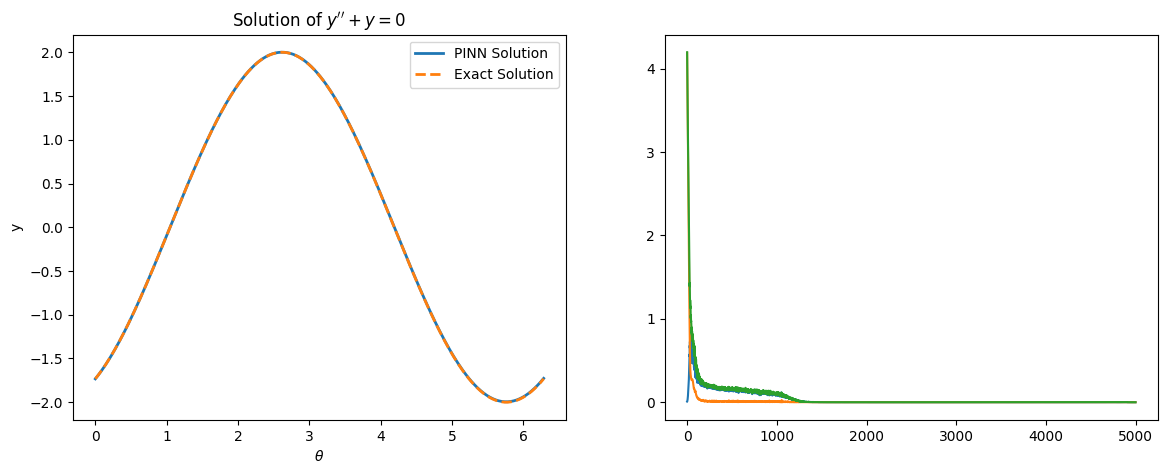

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# PINN Neural Network
# ===============================
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

# ===============================
# Physics Loss: y'' + y = 0
# ===============================
def physics_loss(model, x):
    x.requires_grad_(True)

    y = model(x)
    y_x = torch.autograd.grad(
        y, x, torch.ones_like(y), create_graph=True
    )[0]
    y_xx = torch.autograd.grad(
        y_x, x, torch.ones_like(y_x), create_graph=True
    )[0]

    residual = y_xx + y
    return torch.mean(residual**2)

# ===============================
# Initial Condition Loss
# y(pi/3) = 0 , y'(pi/3) = 2
# ===============================
def initial_condition_loss(model):
    theta0 = torch.tensor([[np.pi / 3]], requires_grad=True)

    y0 = model(theta0)
    y0_x = torch.autograd.grad(
        y0, theta0, torch.ones_like(y0), create_graph=True
    )[0]

    loss_y = (y0 - 0.0)**2
    loss_dy = (y0_x - 2.0)**2

    return loss_y.mean() + loss_dy.mean()

# ===============================
# Training Function
# ===============================
def train_pinn(model, optimizer, epochs=5000):
    physics_losses = []
    ic_losses = []
    total_losses = []

    for epoch in range(epochs):
        theta = torch.rand(256, 1) * 2 * np.pi

        p_loss = physics_loss(model, theta)
        ic_loss = initial_condition_loss(model)

        total_loss = p_loss + ic_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        physics_losses.append(p_loss.item())
        ic_losses.append(ic_loss.item())
        total_losses.append(total_loss.item())

        if epoch % 500 == 0:
            print(
                f"Epoch {epoch} | "
                f"Physics Loss: {p_loss.item():.6e} | "
                f"IC Loss: {ic_loss.item():.6e} | "
                f"Total Loss: {total_loss.item():.6e}"
            )

    return physics_losses, ic_losses, total_losses

# ===============================
# Main Program
# ===============================
if __name__ == "__main__":

    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    physics_losses, ic_losses, total_losses = train_pinn(
        model, optimizer, epochs=5000
    )

    # Test Domain
    theta_test = torch.linspace(0, 2*np.pi, 300).reshape(-1, 1)
    y_pinn = model(theta_test).detach().numpy()

    # Exact Solution
    y_exact = -np.sqrt(3)*np.cos(theta_test.numpy()) + np.sin(theta_test.numpy())

    # ===============================
    # Plotting
    # ===============================
    plt.figure(figsize=(14,5))

    # Solution plot
    plt.subplot(1,2,1)
    plt.plot(theta_test, y_pinn, label="PINN Solution", linewidth=2)
    plt.plot(theta_test, y_exact, '--', label="Exact Solution", linewidth=2)
    plt.xlabel(r"$\theta$")
    plt.ylabel("y")
    plt.title(r"Solution of $y'' + y = 0$")
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(physics_losses, label="Physics Loss")
    plt.plot(ic_losses, label="Boundary / IC Loss")
    plt.plot(total_losses, label="Total Loss")
    plt
